In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.combine import SMOTETomek
import warnings
warnings.filterwarnings("ignore")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "svg"

In [2]:
# Load the data
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
data.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

## 1. Exploratory Data Analysis

In [3]:
data.shape

(7043, 21)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
data.describe().T

count       mean        std    min   25%    50%    75%  \
SeniorCitizen   7043.0   0.162147   0.368612   0.00   0.0   0.00   0.00   
tenure          7043.0  32.371149  24.559481   0.00   9.0  29.00  55.00   
MonthlyCharges  7043.0  64.761692  30.090047  18.25  35.5  70.35  89.85   

                   max  
SeniorCitizen     1.00  
tenure           72.00  
MonthlyCharges  118.75

In [6]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

#### No Missing Value !!


#### 1. Churn - Target Feature 

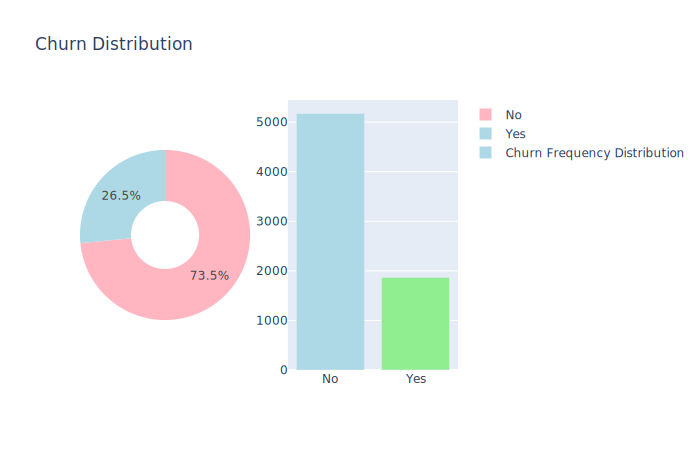

In [7]:
# Churn
churn_df = data['Churn'].value_counts()
fig = make_subplots(rows = 1, cols = 2, specs=[[{"type": "pie"}, {"type": "bar"}]])
colors_pie = ['lightpink','lightblue']
colors_bar = ['lightblue', 'lightgreen']
fig.add_trace(go.Pie(
    values = churn_df.values,
    labels = churn_df.index,
    hole = 0.4,
    name = 'Churn Distribution',
    marker = dict(colors = colors_pie)
), row = 1, col = 1)

fig.add_trace(go.Bar(
    x = churn_df.index,
    y = churn_df.values,
    name = 'Churn Frequency Distribution',
    marker = dict(color = colors_bar),
), row = 1, col = 2)

fig['layout'].update(title = 'Churn Distribution')

iplot(fig)

#### 73.5% are customer who are retained and 26.5% are customer who are churned. We have imbalanced dataset here.

In [8]:
# 1. Customer ID - Unique ID of customer
data['customerID'].nunique()

7043

#### Customer ID  we can drop as it won't be required for prediction 

In [9]:
data['gender'] = data['gender'].map({'Male' : 0, 'Female' : 1})
data['Churn'] = data['Churn'].map({'Yes' : 1, 'No' : 0})

In [10]:
cat_features = []
feature_names = data.columns
for feature in feature_names:
    if data[feature].dtype == 'O':
        cat_features.append(feature)
        
print(cat_features)        

['customerID', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']


In [11]:
data['TotalCharges'] = data['TotalCharges'].replace(" ", 0).astype('float32')

In [12]:
feature_names = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

In [13]:
data.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG       1              0     Yes         No       1           No   
1  5575-GNVDE       0              0      No         No      34          Yes   
2  3668-QPYBK       0              0      No         No       2          Yes   
3  7795-CFOCW       0              0      No         No      45           No   
4  9237-HQITU       1              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges  Churn  
0           Electronic check          29.85     29.850000      0  
1               Mailed check          56.95   1889.500000      0  
2               Mailed check          53.85    108.150002      1  
3  Bank transfer (automatic)          42.30   1840.750000      0  
4           Electronic check          70.70    151.649994      1  

[5 rows x 21 columns]

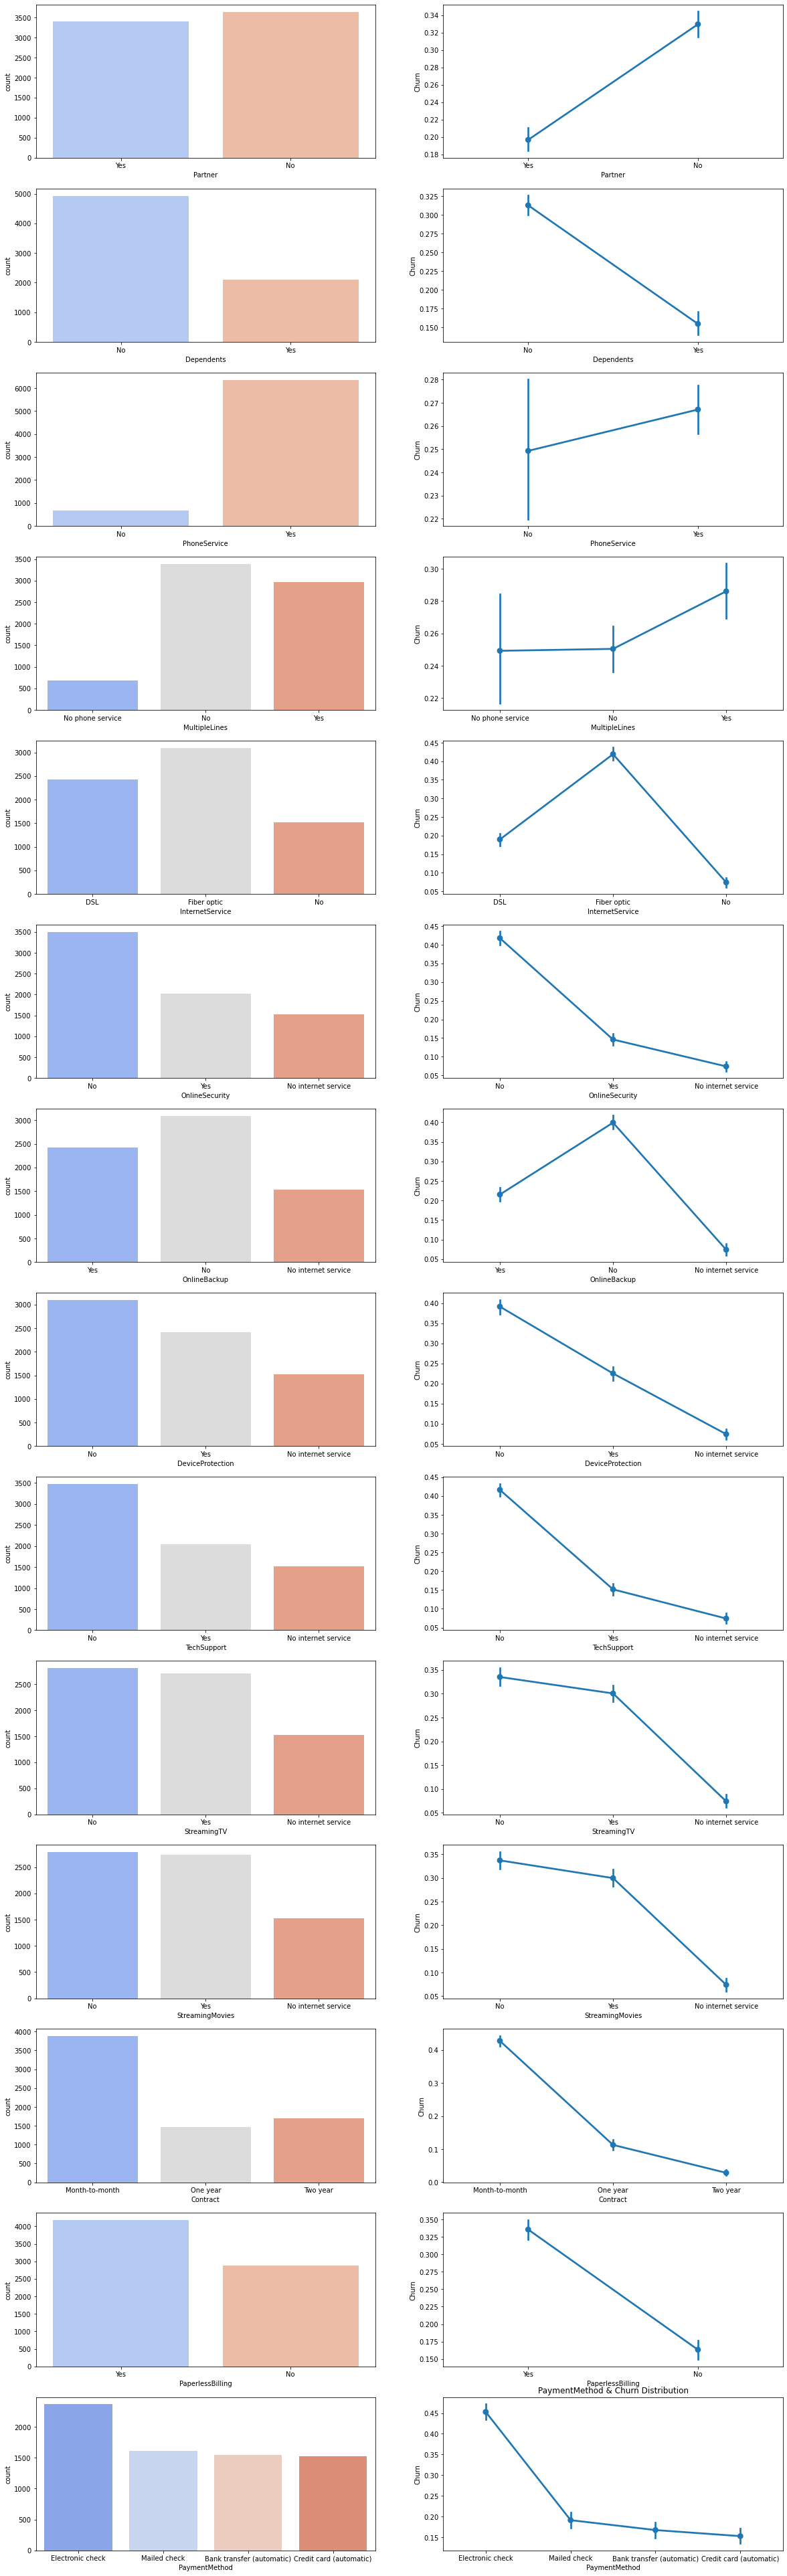

In [14]:
fig, ax = plt.subplots(14,2, figsize = (20, 70)) 
row = 0
for feature in feature_names:
    sns.countplot(x = data[feature], ax = ax[row][0], palette = 'coolwarm')
    plt.title(feature + ' Distribution')
    sns.pointplot(x = feature, y = 'Churn', data = data, ax = ax[row][1])
    plt.title(feature + ' & Churn Distribution')
    row = row + 1

* People having multiple phone lines are tend to move out more
* Customer having Fiber optic tend to move out more
* Majority of Churned customer are Females
* We have few customer's who are Senior Citizen, but the churn rate is high for Senior Citizens
* We have more customer who are single and the churn rate is also high for customer's who are single
* Majority of Churned customer are Females
* We have high churn rate for customer who are single

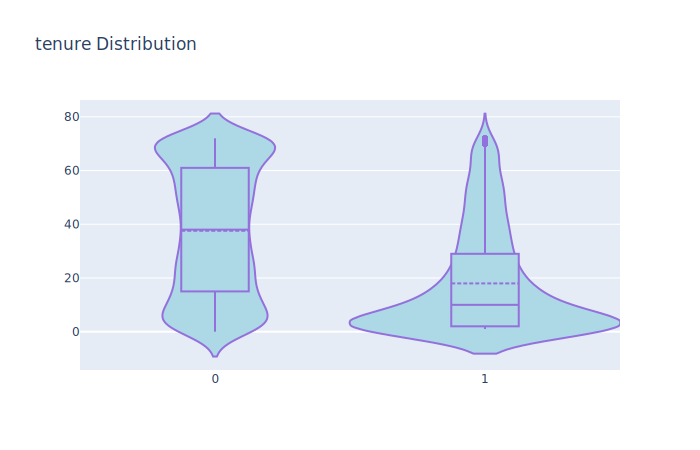

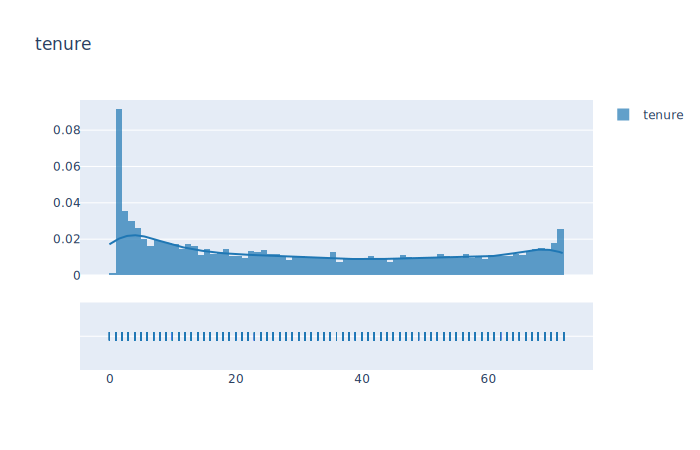

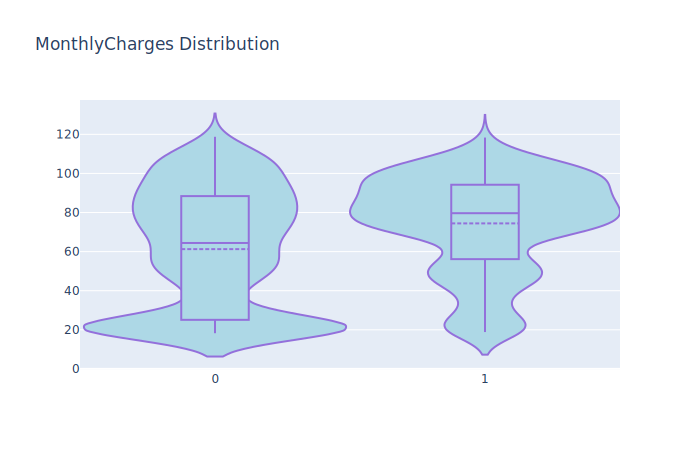

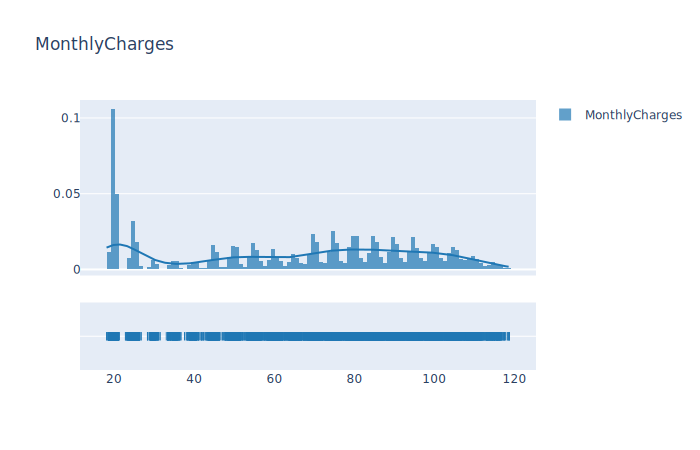

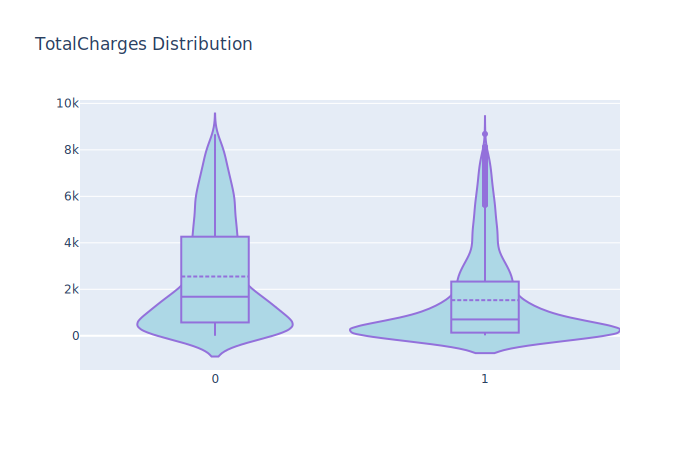

In [15]:
numeric_features = ['tenure','MonthlyCharges','TotalCharges']
for feature in numeric_features:

    data1 = go.Violin(x = data['Churn'], y = data[feature] , box_visible=True, line_color='mediumpurple',
                                   meanline_visible=True, fillcolor='lightblue')
    fig = go.Figure([data1])
    fig.update_layout(title_text = feature + " Distribution", violingap=0, violingroupgap=0, violinmode='overlay')
    iplot(fig)
    
    fig = ff.create_distplot(hist_data = [data[feature]],
                            group_labels = [feature])
    fig['layout'].update(title = feature)
    iplot(fig)
                  

* Customer having less tenure are tend to leave soon
* Customer having higher monthly charges tend to leave
* Customer having low total charges (new customer) tend to leave
* Montlhly Charges & Total Charges tend to be skewed on right

## 2. Feature Engineering

In [16]:
data.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG       1              0     Yes         No       1           No   
1  5575-GNVDE       0              0      No         No      34          Yes   
2  3668-QPYBK       0              0      No         No       2          Yes   
3  7795-CFOCW       0              0      No         No      45           No   
4  9237-HQITU       1              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges  Churn  
0           Electronic check          29.85     29.850000      0  
1               Mailed check          56.95   1889.500000      0  
2               Mailed check          53.85    108.150002      1  
3  Bank transfer (automatic)          42.30   1840.750000      0  
4           Electronic check          70.70    151.649994      1  

[5 rows x 21 columns]

In [17]:
# Drop customer ID as not required for prediction
data.drop(['customerID'], axis = 'columns', inplace = True)

<AxesSubplot:>

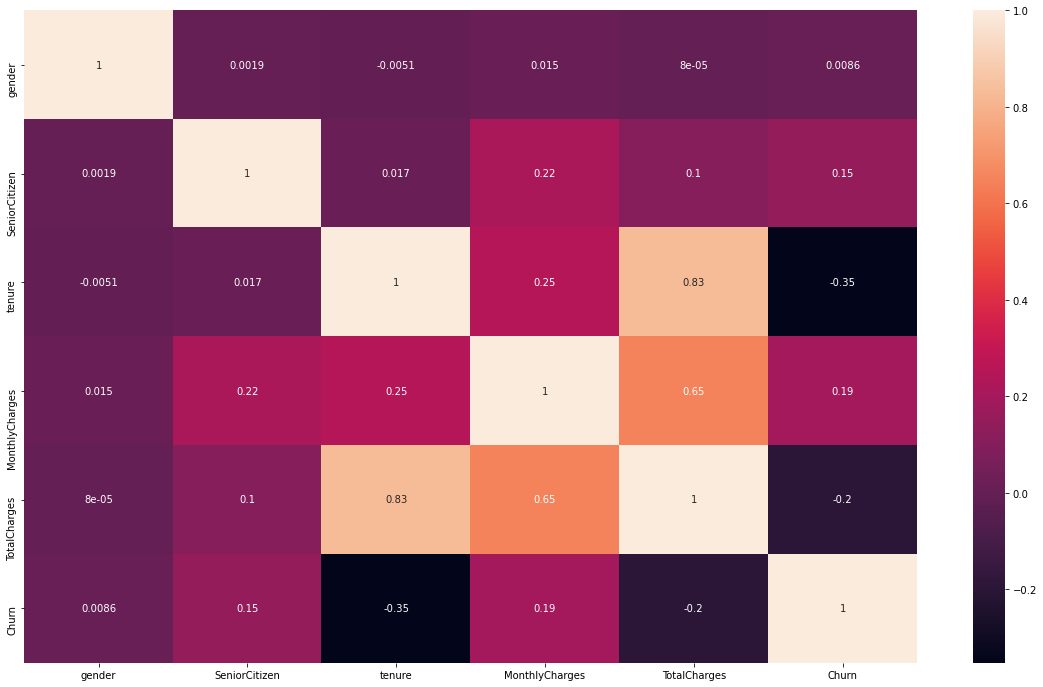

In [18]:
plt.rcParams['figure.figsize'] = (20, 12)
sns.heatmap(data.corr(), annot = True)

In [19]:
data = pd.get_dummies(data, drop_first = True)

## 3. Model Training

In [20]:
# Show Metrics

def show_metrics(y_test, y_pred):
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print(' Precision Score {:.3f}'.format(precision))
    print(' Recall Score {:.3f}'.format(recall))
    print(' F1 Score {:.3f}'.format(f1score))
    print(' Accuracy Score {:.3f}'.format(accuracy))

In [21]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.rcParams['figure.figsize'] = (4,4)
    sns.heatmap(cm, annot = True, fmt = "d", linewidths = 0.3)

In [22]:
features = ['tenure','Contract_Two year','TotalCharges','Contract_One year','MonthlyCharges','OnlineSecurity_Yes','TechSupport_Yes','Dependents_Yes','InternetService_Fiber optic','OnlineBackup_Yes']
# X = data[features]
X = data.drop(['Churn'], axis = 'columns')
y = data['Churn']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [24]:
# SMOTE TECHNIQUE FOR inbalance dataset

smt = SMOTETomek(random_state=42)
X_train_resample, y_train_resample = smt.fit_sample(X_train, y_train)
print(X_train_resample.shape)

(6608, 30)


In [25]:
# Cross Validation

scores = []
std = []
accuracy = []
kfold = KFold(n_splits = 10)
classifiers  = ['Logistic Regression', 'Naive Bayes', 'SVM', 'KNeighbours','Decision Tree', 'Random Forest', 
                'GradientBoostingClassifer','AdaBoostClassifier','XGBClassifier']
models = [
    LogisticRegression(),
    GaussianNB(),
    SVC(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    XGBClassifier()
]

for model in models:
    cv_result = cross_val_score(model, X_train_resample, y_train_resample, cv = kfold, scoring = 'accuracy')
    scores.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
    
model_result = pd.DataFrame({'Mean': scores, 'Std' : std}, index = classifiers).sort_values(by = 'Mean', ascending = False)
model_accuracy = pd.DataFrame(accuracy, index = classifiers)
print(model_result)

                               Mean       Std
Random Forest              0.855509  0.068573
XGBClassifier              0.848549  0.071921
GradientBoostingClassifer  0.844462  0.070482
AdaBoostClassifier         0.835989  0.077198
Logistic Regression        0.831597  0.067338
Decision Tree              0.815257  0.070664
Naive Bayes                0.814353  0.084771
KNeighbours                0.794362  0.049491
SVM                        0.637532  0.063712


<AxesSubplot:>

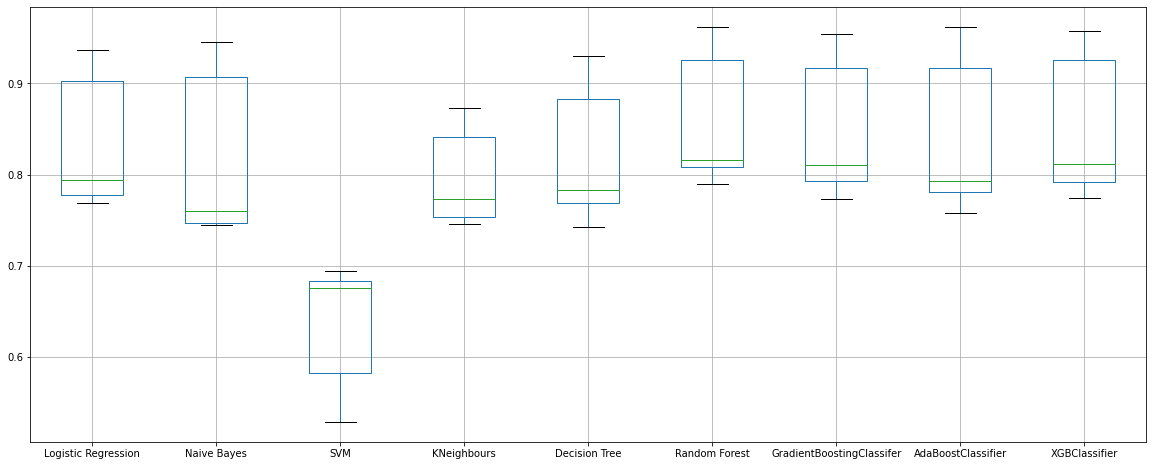

In [26]:
plt.rcParams['figure.figsize'] = (20,8)
model_accuracy.T.boxplot()

In [27]:
# Hyper Parameter Tunning - Logistic Regression
lr_model = LogisticRegression( )
params = {
            'penalty' : ['l1','l2'], 
            'class_weight' : ['balanced', None], 
            'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}
cv = GridSearchCV(estimator = lr_model, param_grid = params, n_jobs = -1, scoring = 'f1', verbose = 10)
cv.fit(X_train_resample, y_train_resample)
print(cv.best_params_)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1877s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1027s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 103 tasks      | elapsed:    2.3s


{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}


[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    2.5s finished


In [28]:
# Best Hyper parameter - Logistic Regression
lr_model = LogisticRegression( C = 0.01, class_weight = 'balanced', penalty = 'l2')
lr_model.fit(X_train_resample, y_train_resample)
lr_pred = lr_model.predict(X_test)
show_metrics(y_test, lr_pred)

# F1 Score 0.621
#  Accuracy Score 0.752

 Precision Score 0.542
 Recall Score 0.694
 F1 Score 0.609
 Accuracy Score 0.766


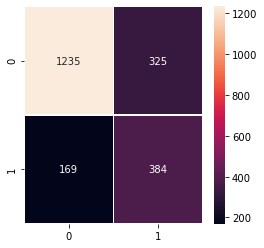

In [29]:
plot_confusion_matrix(y_test, lr_pred)

In [30]:
# Gradient Boosting Classifier Hyper Parameter tunning

n_estimators = [100, 200, 500, 1000]
max_depths = [1,3, 5, 10]
params = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depths,
}
gd = GridSearchCV(estimator = XGBClassifier(), param_grid = params, verbose = True, n_jobs = -1)
gd.fit(X, y)
print(gd.best_score_)
print(gd.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   26.3s finished


0.8069010500677463
{'max_depth': 3, 'n_estimators': 100}


In [31]:
# Best Hyper parameter - Gradient Boosting
xgb_model = XGBClassifier(max_depth = 3, n_estimators = 100)
xgb_model.fit(X_train_resample, y_train_resample)
xgb_pred = xgb_model.predict(X_test)
show_metrics(y_test, xgb_pred)

 Precision Score 0.549
 Recall Score 0.693
 F1 Score 0.612
 Accuracy Score 0.770


In [32]:
# Hyper parameter tunning - Random Forest
n_estimator = range(100, 1000, 100)
max_depth = [1,3, 5, 10]
params = {'n_estimators' : n_estimator, 'max_depth' : max_depth }
rf_model = RandomForestClassifier()
gd = GridSearchCV(estimator = rf_model, param_grid = params, verbose = True, n_jobs = -1)
gd.fit(X_train_resample, y_train_resample)
print(gd.best_score_)
print(gd.best_params_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   32.0s finished


0.8483764534500866
{'max_depth': 10, 'n_estimators': 100}


In [33]:
# Random Forest best Hyper parameters
rf_model = RandomForestClassifier(n_estimators = 500, max_depth = 10)
rf_model.fit(X_train_resample, y_train_resample)
rf_pred = rf_model.predict(X_test)
show_metrics(y_test, rf_pred)

 Precision Score 0.540
 Recall Score 0.703
 F1 Score 0.611
 Accuracy Score 0.765


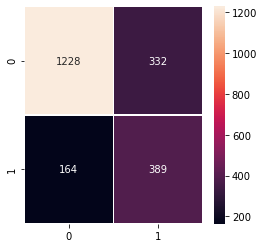

In [34]:
plot_confusion_matrix(y_test, rf_pred)

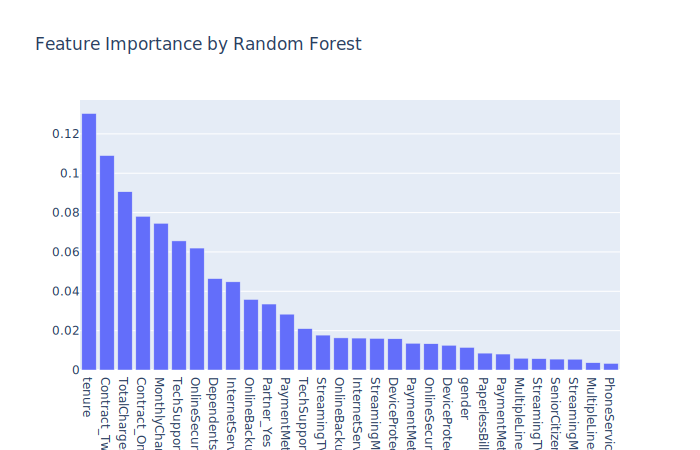

In [35]:
feature_importance = pd.DataFrame({'Feature' : X_train.columns, 'Importance': rf_model.feature_importances_}).sort_values(by = 'Importance', ascending = False)
data1 = go.Bar(
    x = feature_importance.Feature,
    y = feature_importance.Importance
)
fig = go.Figure([data1])
fig['layout'].update(title = 'Feature Importance by Random Forest', height = 800)
iplot(fig)